***
# What's Cooking? Phase I
***

A Kaggle competition to predict the origin of the cuisine based on the ingredients. Using the robust **`RingVision`** Machine Learning Process the objective is to achieve a score above best posted score of **[0.83216](https://www.kaggle.com/c/whats-cooking/leaderboard)**.  The submissions (predictions) will be in CSV format with one column for id and the second for the respected predicted cuisine.  Scoring is based on categorization accuracy.

* [Overview](https://www.kaggle.com/c/whats-cooking/overview)
* [Data](https://www.kaggle.com/c/whats-cooking/data)
* [Rules](https://www.kaggle.com/c/whats-cooking/rules)

***
# Index
***

* [**Imports**](#import)
* [**Custom Functions**](#cust)
* [**Exploratory Data Analysis**](#eda)
* [**Feature Engineering/Data Preparing**](#feature)
* [**Next Steps**](#next)

<a id="---"></a>

<a id="import"></a>
# Imports

In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

<a id="cust"></a>
# Custom Functions

In [2]:
def hist_bins(d_frame, col_name, 
               title="",y_axis="",x_axis="",adder = 0, start = 0, stop = 0):
    '''Create a histogram with adjusted bins'''
    bin_edges = np.arange(start, stop + adder, adder)

    plt.axvline(d_frame[col_name].median(),color='y',linestyle='--',lw=2,label='Median')
    plt.axvline(d_frame[col_name].mean(),color='r',linestyle='--',lw=2,label='Mean')
    
    plt.title(title,fontsize=14)
    plt.ylabel(y_axis,fontsize=14)
    plt.xlabel(x_axis,fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    return plt.hist(d_frame[col_name], bins = bin_edges);

<a id="eda"></a>
# Exploratory Data Analysis 

In [3]:
df = pd.read_json('whats_cooking_train.json')
new = pd.read_json('whats_cooking_test.json')

In [4]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
df.tail()

,id,cuisine,ingredients
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."
39773,2362,mexican,"[green chile, jalapeno chilies, onions, ground..."


The training data is 39,774 observations with 3 features. The testing data is 9,944 by 2. It does not contain the features 'cuisine' which is the variable we want to predict. 

In [6]:
print(f"Shape of Training Data:\t {df.shape}")
print(f"Shape of Testing Data:\t {new.shape}")

Shape of Training Data:	 (39774, 3)
Shape of Testing Data:	 (9944, 2)


The features are not missing any values and the data types for each feature should be fine.

In [7]:
print(df.info())
print('-'*45)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
---------------------------------------------
id             0
cuisine        0
ingredients    0
dtype: int64


## Feature Review **`Cuisine`**

- Italian, Mexican and Southern_US are the the top three locations and represent about **45%** of the total mix. 
- There are 20 locations that the list of ingredients could have originated from

In [8]:
by_cuisine = df['cuisine'].value_counts(normalize=True)
by_cuisine

italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64

In [9]:
print(f"Location Count is: {by_cuisine.count()}")

Location Count is: 20


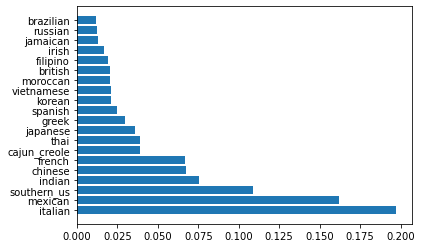

In [10]:
plt.barh(list(by_cuisine.index),list(by_cuisine));

Our predict value is skewed. Our mean location is around 2,000 predictions and our median is 1,000.

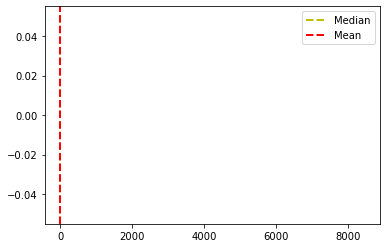

In [11]:
bin_edges = np.arange(450,8000+500,500)
plt.axvline(by_cuisine.median(),color='y',linestyle='--',lw=2,label='Median')
plt.axvline(by_cuisine.mean(),color='r',linestyle='--',lw=2,label='Mean')
plt.legend()
plt.hist(by_cuisine, bins=bin_edges);

In [12]:
df.columns

Index(['id', 'cuisine', 'ingredients'], dtype='object')

## Feature Review **`Ingredients`**
The 'ingredients' feature is a list of ingredients. We will need to convert this list to a list of strings if we want to convert to a document-term-matrix.  Also, adding an ingredient count might be a nice feature we could add that would a predictive value. 

In [13]:
# first row
df.loc[0,'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [14]:
# number of ingredients first observation 
len(df.loc[0,'ingredients'])

9

<a id="sum_eda"></a>
## Summary EDA 

**Observations**
- The predict value is skewed but the not bad enough that we should be concerned about a resulting high error rate.
- 3 cuisines represent 45% of the predicted origin location 
- There are 20 locations that we can predict 
- Italian has the most prediction and will be used for setting the `null accuracy` 

**To Do**

- Create a feature that is the ingredients only
- Convert the list if ingredients to a string 


<a id="feature"></a>
# Feature Engineering/Data Preparing 

## Ingredient Count 
Adding a feature called `num_ingredients` that will provide the count of ingredients for each observation. 

In [15]:
# add feature num_ingredients
df['num_ingredients'] = df['ingredients'].apply(len)

In [16]:
df.head()

,id,cuisine,ingredients,num_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,22213,indian,"[water, vegetable oil, wheat, salt]",4
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20


The ingredient count has a mean of 10 with a standard deviation of 4. 

In [17]:
df['num_ingredients'].describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: num_ingredients, dtype: float64

In [18]:
print(f"1-Std Dev: {10.767713+4.428978}")
print(f"2-Std Dev: {10.767713+4.428978*2}")
print(f"3-Std Dev: {10.767713+4.428978*3}")

1-Std Dev: 15.196691000000001
2-Std Dev: 19.625669000000002
3-Std Dev: 24.054647


In [19]:
less_outliers = df.query('num_ingredients < 25')
print(f"Count > 3 Std Dev: {df.shape[0] - less_outliers.shape[0]}")

Count > 3 Std Dev: 241


In [20]:
less_outliers['num_ingredients'].describe()

count    39533.000000
mean        10.660941
std          4.206394
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         24.000000
Name: num_ingredients, dtype: float64

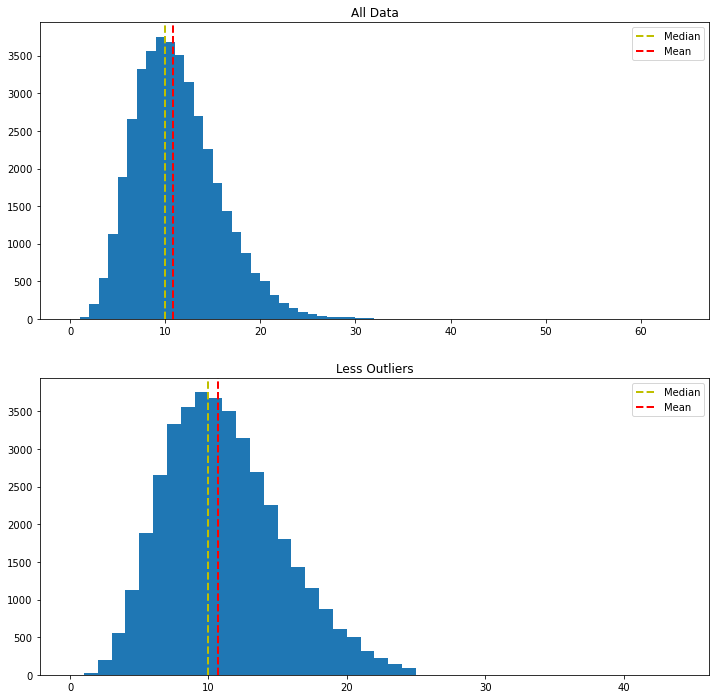

In [21]:
# plot with and withour outliers
plt.figure(figsize = [12,12])
plt.subplot(2,1,1)
bin_edges = np.arange(0,65,1)
plt.axvline(df['num_ingredients'].median(),color='y',linestyle='--',lw=2,label='Median')
plt.axvline(df['num_ingredients'].mean(),color='r',linestyle='--',lw=2,label='Mean')
plt.title('All Data')
plt.legend()
plt.hist(df['num_ingredients'], bins=bin_edges);

plt.subplot(2,1,2)
bin_edges = np.arange(0,45,1)
plt.axvline(less_outliers['num_ingredients'].median(),color='y',linestyle='--',lw=2,label='Median')
plt.axvline(less_outliers['num_ingredients'].mean(),color='r',linestyle='--',lw=2,label='Mean')
plt.title('Less Outliers')
plt.legend()
plt.hist(less_outliers['num_ingredients'], bins=bin_edges);

There is not a lot of variation in the number of ingredients. Here we take a look at all cuisines based on the full dataset. Then we remove anything > 3 standard deviations from the mean. The cuisines have a large overlap. We wanted to see more variation which would lead to a better predictor or cuisine origin. 

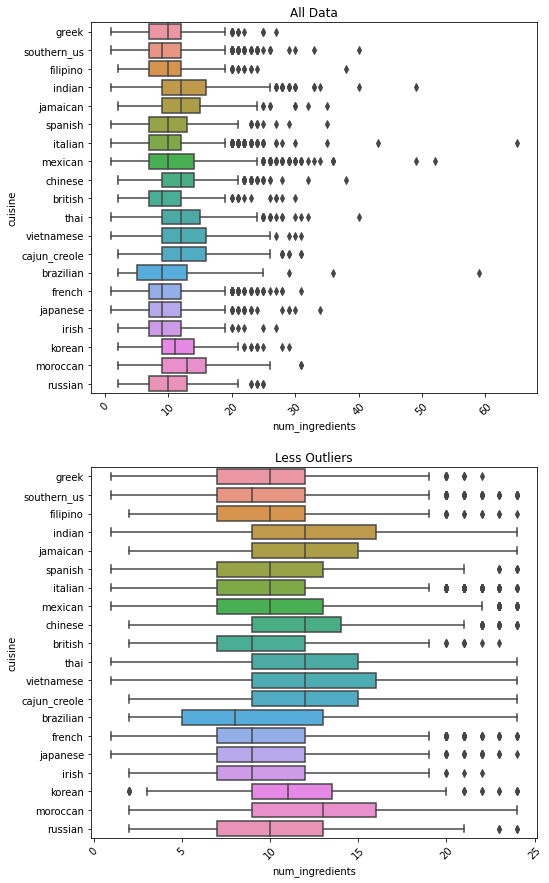

In [22]:
# boxplot with and without outliers
plt.figure(figsize = [8, 15])
plt.subplot(2,1,1)
plt.xticks(rotation=45)
plt.title('All Data')
sns.boxplot(x=df['num_ingredients'],y=df['cuisine']);

plt.subplot(2,1,2)
plt.xticks(rotation=45)
plt.title('Less Outliers')
sns.boxplot(x=less_outliers['num_ingredients'],y=less_outliers['cuisine']);

In [23]:
group = df.groupby(['cuisine',])['num_ingredients'].mean()
group = group.sort_values()
group

cuisine
irish            9.299850
brazilian        9.520343
southern_us      9.634954
british          9.708955
japanese         9.735067
french           9.817838
italian          9.909033
filipino        10.000000
greek           10.182128
russian         10.224949
spanish         10.423660
mexican         10.877446
korean          11.284337
chinese         11.982791
jamaican        12.214829
thai            12.545809
cajun_creole    12.617076
vietnamese      12.675152
indian          12.705961
moroccan        12.909866
Name: num_ingredients, dtype: float64

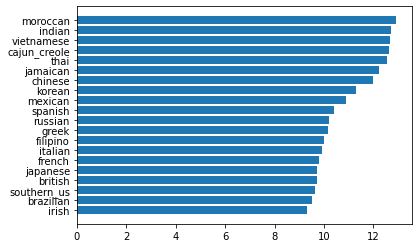

In [24]:
plt.barh(list(group.index),list(group));

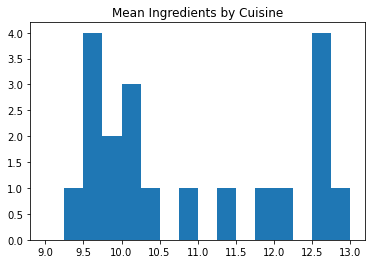

In [25]:
#plt.figure(figsize = [12,12])
bin_edges = np.arange(9,13+0.25,0.25)
plt.title('Mean Ingredients by Cuisine')
plt.hist(group, bins=bin_edges);

Checking the extreme outliers for mistakes.  There are 5 cuisines that have more than 45 ingredients and they do not appear to be correct. 

In [26]:
# look at cuisine with ingredient count 45 plus
plus_45 = df[df['num_ingredients'] > 40]
plus_45.head()

,id,cuisine,ingredients,num_ingredients
10513,49282,mexican,"[condensed cream of chicken soup, pepper, refr...",49
15289,3885,italian,"[fettucine, fresh marjoram, minced garlic, oli...",65
22906,2253,indian,"[white vinegar, sparkling lemonade, coconut su...",49
26103,13049,mexican,"[vanilla ice cream, lime, garlic powder, zucch...",52
30350,13430,brazilian,"[marshmallows, fresh corn, cheddar cheese, shr...",59


In [27]:
# italian at 65
print(df.loc[15289,'ingredients'])

['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pepper', 'grated parmesan cheese', 'boneless skinless chicken breasts', 

In [28]:
# brazilian max at 59
print(df.loc[30350,'ingredients'])

['marshmallows', 'fresh corn', 'cheddar cheese', 'shredded coconut', 'water', 'honey', 'baking soda', 'dijon mustard', 'sweet potatoes', 'chicken breasts', 'vegetable oil', 'salt', 'condensed milk', 'candy', 'canola oil', 'eggs', 'brown sugar', 'glutinous rice', 'white onion', 'dashi', 'whole wheat flour', 'oat flour', 'flour', 'boneless skinless chicken breasts', 'fresh thyme leaves', 'sprinkles', 'grated lemon zest', 'ham', 'white sugar', 'avocado', 'chili flakes', 'coconut oil', 'skim milk', 'pepper', 'kale', 'parmesan cheese', 'unsalted butter', 'tapioca starch', 'baking powder', 'parsley', 'vanilla extract', 'cream cheese', 'coconut milk', 'chocolate chips', 'low sodium soy sauce', 'powdered sugar', 'sugar', 'muffin', 'milk', 'olive oil', 'bananas', 'large eggs', 'green onions', 'swiss cheese', 'butter', 'all-purpose flour', 'dark brown sugar', 'panko breadcrumbs', 'low-fat milk']


## Ingredient Length 
Here we want to explore adding a feature that will be the mean ingredient length for each observation. We can then group by the cuisine and calculate the mean length.. The new feature added will be called:

* New Feature Added: `**avg_ingredient_len**`

In [29]:
# first observation has 9 ingredients 
ing_cnt= len(df.loc[0,'ingredients'])
print(f"Ingredient Count: {ing_cnt}")

Ingredient Count: 9


In [30]:
# manually count ingredients should be 9
df.loc[0,'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [31]:
# calculate the avg ing length add to dataframe
num_ingred = 0
avg_length =[]
for i in df.itertuples():
    ing_length = 0
    num_ingred = len(i.ingredients)
    # get the length each ingredient
    for ing in i.ingredients:
        ing_length += len(ing)
    avg_length.append(round(ing_length / num_ingred,2))
    
df['avg_ingredient_len'] = avg_length
df.head()

,id,cuisine,ingredients,num_ingredients,avg_ingredient_len
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.00
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.09
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.33
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.75
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.10


Looking at the mean ingredient length by cuisine we see that Italian, Mexican and Greek round out the top three.  We know that Italian also has the most predictions. Wondering if looking at the median might provide a different picture? We typically think of Italian as simple and only a few ingredients. Why are they so high? 

In [32]:
# calculate mean ingredient length by cuisine
group2 = df.groupby('cuisine')['avg_ingredient_len'].mean()
group2 = group2.sort_values()
group2

cuisine
filipino         9.813815
japanese        10.050225
russian         10.267444
korean          10.397602
brazilian       10.565268
jamaican        10.612433
british         10.746716
indian          10.842224
irish           10.950435
vietnamese      11.021321
chinese         11.517886
moroccan        11.518417
southern_us     11.530602
spanish         11.720253
french          11.909180
thai            11.986621
cajun_creole    12.022270
greek           12.117140
mexican         12.167196
italian         12.814340
Name: avg_ingredient_len, dtype: float64

In [33]:
print(f"Min Mean Ingredient Length by Cuisine: {group2.min()}")
print(f"Max Mean Ingredient Length by Cuisine: {group2.max()}")

Min Mean Ingredient Length by Cuisine: 9.813814569536433
Max Mean Ingredient Length by Cuisine: 12.81434039295739


In [34]:
# calcualte the median assign to GROUP3
group3 = df.groupby('cuisine')['avg_ingredient_len'].median()
group3 = group3.sort_values()
group3

cuisine
filipino         9.80
japanese        10.00
russian         10.24
korean          10.31
brazilian       10.50
jamaican        10.61
indian          10.67
british         10.88
irish           10.88
vietnamese      10.94
chinese         11.40
moroccan        11.50
southern_us     11.50
spanish         11.77
thai            11.83
french          11.90
cajun_creole    11.93
greek           12.00
mexican         12.00
italian         12.69
Name: avg_ingredient_len, dtype: float64

In [35]:
# median 
print(f"Min Median Ingredient Length by Cuisine: {group3.min()}")
print(f"Max Median Ingredient Length by Cuisine: {group3.max()}")

Min Median Ingredient Length by Cuisine: 9.8
Max Median Ingredient Length by Cuisine: 12.69


Here we look at two histograms side-by-side of the` mean ingredient length` and `mean ingredient count` **by cuisine**. The length is a little more centered with bimodal peaks in the center. Where the count has its peaks on the edges.  Individually, we do not think either will be beneficial to predicting the cuisine. `However, maybe a ensemble of the two might provide a better predictor`? 

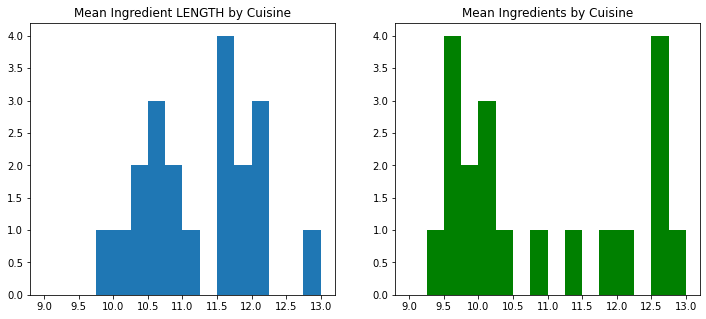

In [36]:
plt.figure(figsize = [12,5])
plt.subplot(1,2,1)
bin_edges = np.arange(9,13+0.25,0.25)
plt.title('Mean Ingredient LENGTH by Cuisine')
plt.hist(group2, bins=bin_edges);

plt.subplot(1,2,2)
bin_edges = np.arange(9,13+0.25,0.25)
plt.title('Mean Ingredients by Cuisine')
plt.hist(group, bins=bin_edges,color='green');

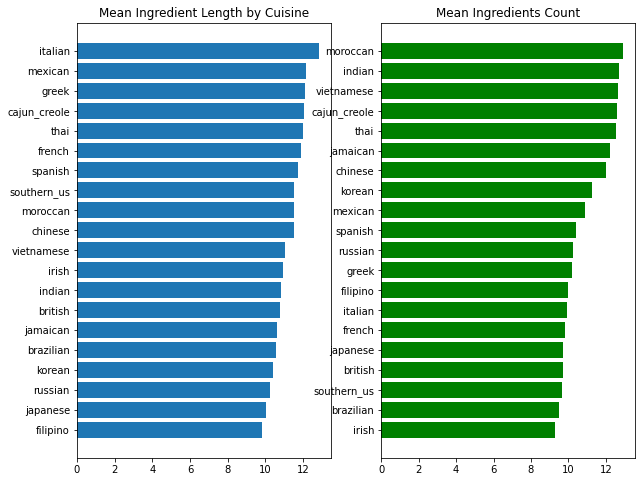

In [37]:
# side-by_side plot ingredient length and ingredient count
plt.figure(figsize = [10, 8])

plt.subplot(1,2,1)
plt.title("Mean Ingredient Length by Cuisine")
plt.barh(list(group2.index),list(group2));

plt.subplot(1,2,2)
plt.title("Mean Ingredients Count")
plt.barh(list(group.index),list(group),color='green');

This is a better look at the mean length and count. Wondering if the difference between the two might be a better feature than the two individual features. The initial assumption is no but it would not take a lot of extra effort to validate a model.  We will add a new feature called `**difference**` which will be the mean length minus the count. A negative value indicates that the number of ingredients for a particular cuisine is greater than the average length of ingredient names. 

* <font color='blue'>Mean Ingredient LENGTH by Cuisine</font>
* <font color='green'>Mean Ingredient COUNT by Cuisine</font>

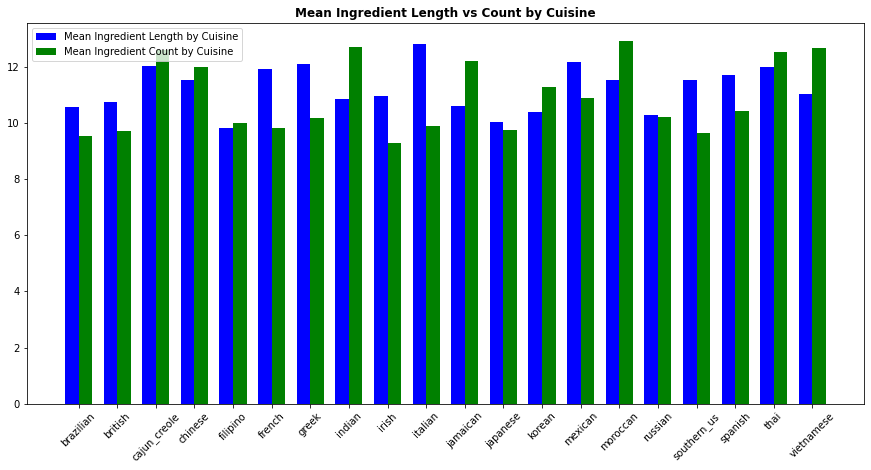

In [38]:
# compare means lenght vs count
plt.figure(figsize = [15, 7])
# mean ingredient length by cuisine blue
mu_ing_len = list(group2.sort_index())
# mean ingredient count by cuisine green
mu_ing_count = list(group.sort_index())
# this could be group or group2 just need labels a - z
labels = sorted(group2.index) 

x = np.arange(len(labels))  
width = 0.35 # Width of bars

plt.bar(x-width/2, mu_ing_len, width,
        label="Mean Ingredient Length by Cuisine",color='blue')
plt.bar(x+width/2, mu_ing_count, width,
        label="Mean Ingredient Count by Cuisine",color='green') 

plt.title("Mean Ingredient Length vs Count by Cuisine",fontweight='bold')
plt.xticks(ticks=x,labels=labels,rotation=45)
plt.legend();


## Difference Feature Add 
We will add a new feature called `**difference**` which will be the mean length minus the count. A negative value indicates that the number of ingredients for a particular cuisine is greater than the average length of ingredient names. 
> `avg_ingredient_len` - `num_ingredients` = **`difference`**

Where positive values indicate avg ingredient length is greater than number of ingredients.

In [39]:
# create new feature and add to the dataframe 
df['difference'] = df['avg_ingredient_len'] - df['num_ingredients']
df.head()

,id,cuisine,ingredients,num_ingredients,avg_ingredient_len,difference
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.00,3.00
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.09,-0.91
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,10.33,-1.67
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,6.75,2.75
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,10.10,-9.90


## Ingredients as String 
We will eventually use CountVectorizer with the feature ingredients to create a document-term-matrix. Currently 'ingredients' is an actual Python list. We need to convert this to a regular string and we should be fine. Including the brackets will not be an issue as they will be omitted with the `token_pattern`.  The apostrophes might add value to the process. If not we can remove later on. 

In [40]:
# convert ingredients feature to a string
df['ingredients_str'] = df['ingredients'].astype(str)

In [41]:
df.head(2)

,id,cuisine,ingredients,num_ingredients,avg_ingredient_len,difference,ingredients_str
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,12.00,3.00,"['romaine lettuce', 'black olives', 'grape tom..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,10.09,-0.91,"['plain flour', 'ground pepper', 'salt', 'toma..."


In [42]:
# validate what we did is correct. grab the first observation, print first and last characters '[' and ']'
# print the fist word of string 'romaine lettuce'
validate = df.loc[0,'ingredients_str']
print(validate[0])
print(validate[-1])
print(validate[1:18])

[
]
'romaine lettuce'


## Custom Feature Function 
Last we want to create a custom function that will take a dataframe and create our three new features. The function will be called: **`new_features`** and will take one argument which is the name of the dataframe. We can validate that it works on the test data that was imported but not part of EDA.

In [43]:
def new_features(df_name):
    '''Create 4 new features for given dataframe'''
    # create feature 1 avg ingredient length
    num_ingred = 0
    avg_length =[]
    for i in df_name.itertuples():
        ing_length = 0
        num_ingred = len(i.ingredients)
        # get the length each ingredient
        for ing in i.ingredients:
            ing_length += len(ing)
        avg_length.append(round(ing_length / num_ingred,2))
    df_name['avg_ingredients_len'] = avg_length  
    # create feature 2 count of ingredients 
    df_name['num_ingredients'] = df_name['ingredients'].apply(len)
    # create feature 3 avg ingredient length
    df_name['difference'] = df_name['avg_ingredients_len'] - df_name['num_ingredients']
    # create feature 4 convert ingredients from list to string 
    df_name['ingredients_str'] = df_name['ingredients'].astype('str')
    return df_name

Apply the function to the dataset **`new`** and validate all four columns have been added and are correct.  

In [44]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9944 non-null   int64 
 1   ingredients  9944 non-null   object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


In [45]:
# apply custom function to the dataset **new**
df_new_validate = new_features(new)
df_new_validate.head(10)

,id,ingredients,avg_ingredients_len,num_ingredients,difference,ingredients_str
0,18009,"[baking powder, eggs, all-purpose flour, raisi...",9.33,6,3.33,"['baking powder', 'eggs', 'all-purpose flour',..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...",10.27,11,-0.73,"['sugar', 'egg yolks', 'corn starch', 'cream o..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil...",9.67,6,3.67,"['sausage links', 'fennel bulb', 'fronds', 'ol..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,...",12.00,21,-9.00,"['meat cuts', 'file powder', 'smoked sausage',..."
4,35687,"[ground black pepper, salt, sausage casings, l...",13.00,8,5.00,"['ground black pepper', 'salt', 'sausage casin..."
5,38527,"[baking powder, all-purpose flour, peach slice...",11.67,9,2.67,"['baking powder', 'all-purpose flour', 'peach ..."
6,19666,"[grape juice, orange, white zinfandel]",10.67,3,7.67,"['grape juice', 'orange', 'white zinfandel']"
7,41217,"[ground ginger, white pepper, green onions, or...",12.06,16,-3.94,"['ground ginger', 'white pepper', 'green onion..."
8,28753,"[diced onions, taco seasoning mix, all-purpose...",16.71,17,-0.29,"['diced onions', 'taco seasoning mix', 'all-pu..."
9,22659,"[eggs, cherries, dates, dark muscovado sugar, ...",9.19,16,-6.81,"['eggs', 'cherries', 'dates', 'dark muscovado ..."


In [46]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   9944 non-null   int64  
 1   ingredients          9944 non-null   object 
 2   avg_ingredients_len  9944 non-null   float64
 3   num_ingredients      9944 non-null   int64  
 4   difference           9944 non-null   float64
 5   ingredients_str      9944 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 466.2+ KB


<a id="sum_feature"></a>
## Summary Feature Engineering/Data Preparing 

**Observations**
- Created feature (1): `Number of Ingredients` which is the count of ingredients in each cuisine
- Created feature (2): `Ingredient Length`  which is the mean length of each ingredient for each cuisine. 
- Created feature (3): `Difference` which is the mean length if ingredients minus the count of ingredients
- Created feature (4): `Ingredients String` convert the list of ingredients to one string per observation 
- Created a custom function `new_features` that can be used to convert datasets to desired format 
- Number of ingredients and length will probably not add value
- `Italian` will be used for `null accuracy`  Score

**To Do**
- [x] Create a feature that is the difference of count of ingredients and mean ingredient length 
- [x] Convert the list of ingredients to a string 
- [ ] Test model to see if feature 3 produces better than feature 1 and 2. The model should not contain all features. 3 is a product of features 1 and 2. They will have high correlation that will lead to model error.  
- [ ] Use Italian for null accuracy score
- [ ] Do we want to scale added features? Maybe simple min-max? 

<a id="next"></a>
# Next Steps

The initial EDA and feature engineering process is completed. Based on the findings and information learned we will move into feature selection which will be rather simple. We have very few features and we already know based on the statistical analysis those engineered features will probably not add value. We can select our features as part of model selection as we want to test the importance.   

* Feature Selection
* Training and Testing Data
* Algorithm Metric **Using accuracy score**
* Model Selection and Evaluation 